In [4]:
from pydub import AudioSegment
import numpy as np
import librosa
import librosa.display
import scipy.ndimage

In [2]:
def load_audio(filename, sr=22050): # 22,050 Hz is standard for audio processing
    # Load with pydub
    audio = AudioSegment.from_file(filename)
    audio = audio.set_channels(1)  # mono
    audio = audio.set_frame_rate(sr)

    # Convert to numpy array
    samples = np.array(audio.get_array_of_samples()).astype(np.float32) / 32768.0  # normalize
    return samples, sr

In [3]:
audio, sr = load_audio("../songs/Karma.m4a")
print(f"Audio shape: {audio.shape}, Sample rate: {sr}")

Audio shape: (4517088,), Sample rate: 22050


In [10]:
def get_spectrogram_peaks(audio, sr, n_fft=2048, hop_length=512, threshold=10):
    # Compute magnitude spectrogram
    S = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))

    # Convert to decibels
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    print(f"S_db min: {S_db.min()}, max: {S_db.max()}")

    # Apply maximum filter to find local peaks
    neighborhood_size = (20, 10)  # freq x time
    local_max = scipy.ndimage.maximum_filter(S_db, size=neighborhood_size) == S_db

    # Threshold to keep only strong peaks
    detected_peaks = (S_db > threshold) & local_max
    peak_freqs, peak_times = np.where(detected_peaks)

    peaks = list(zip(peak_times, peak_freqs))  # time index, freq bin
    return peaks, S_db

In [14]:
audio, sr = load_audio("../songs/Taylor Swift - Delicate.m4a")
peaks, S_db = get_spectrogram_peaks(audio, sr, threshold=-40)

print(f"Found {len(peaks)} peaks.")


S_db min: -80.0, max: 0.0
Found 11989 peaks.


In [15]:
import matplotlib.pyplot as plt

def plot_peaks(S_db, peaks):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=22050, hop_length=512, x_axis='time', y_axis='log')
    times, freqs = zip(*peaks)
    plt.scatter(times, freqs, color='red', s=5)
    plt.title("Spectrogram with Peaks")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


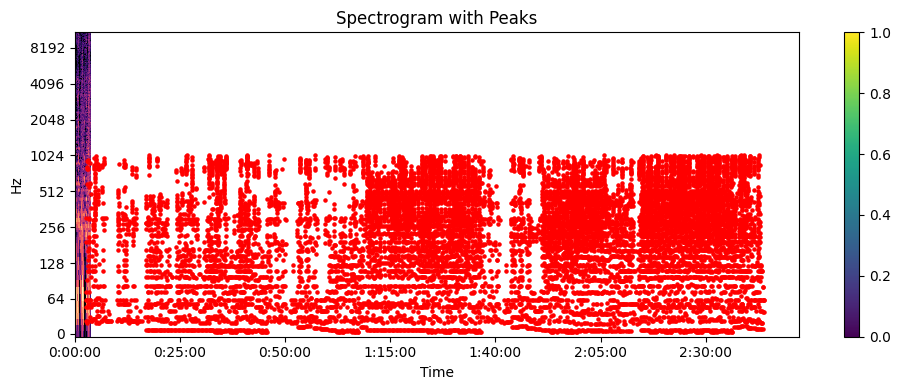

In [16]:
plot_peaks(S_db, peaks)

In [17]:
def generate_fingerprints(peaks, fan_value=5, min_delta=0, max_delta=200):
    fingerprints = []
    for i in range(len(peaks)):
        t1, f1 = peaks[i]
        for j in range(1, fan_value + 1):
            if i + j >= len(peaks):
                break
            t2, f2 = peaks[i + j]
            delta_t = t2 - t1
            if min_delta <= delta_t <= max_delta:
                hash_val = (f1, f2, delta_t)
                fingerprints.append((hash_val, t1))
    return fingerprints


In [18]:
fingerprints = generate_fingerprints(peaks)
print(f"Generated {len(fingerprints)} fingerprints.")

Generated 15460 fingerprints.


In [19]:
from collections import defaultdict

class FingerprintDB:
    def __init__(self):
        self.db = defaultdict(list)
        self.song_ids = {}  # map song_id to title

    def add_song(self, song_id, title, fingerprints):
        self.song_ids[song_id] = title
        for hash_val, t1 in fingerprints:
            self.db[hash_val].append((song_id, t1))

    def get_matches(self, fingerprints):
        matches = []
        for hash_val, t_query in fingerprints:
            if hash_val in self.db:
                for song_id, t_db in self.db[hash_val]:
                    delta = t_db - t_query
                    matches.append((song_id, delta))
        return matches


In [20]:
import os

def load_all_songs_from_directory(directory, db):
    song_id = 0
    for filename in os.listdir(directory):
        if filename.lower().endswith(".m4a"):
            path = os.path.join(directory, filename)
            print(f"Processing {filename}...")

            audio, sr = load_audio(path)
            peaks, _ = get_spectrogram_peaks(audio, sr, threshold=-40)
            fingerprints = generate_fingerprints(peaks)

            db.add_song(song_id=song_id, title=filename, fingerprints=fingerprints)
            song_id += 1


In [21]:
db = FingerprintDB()
load_all_songs_from_directory("../songs", db)
print(f"Database loaded with {len(db.song_ids)} songs.")

Processing I Did Something Bad.m4a...
S_db min: -80.0, max: 0.0
Processing Karma.m4a...
S_db min: -80.0, max: 0.0
Processing PSY - GANGNAM STYLE(강남스타일) M⧸V.m4a...
S_db min: -80.0, max: 0.0
Processing Taylor Swift - Delicate.m4a...
S_db min: -80.0, max: 0.0
Processing Taylor Swift – mirrorball (Official Lyric Video).m4a...
S_db min: -80.0, max: 0.0
Database loaded with 5 songs.


In [22]:
from collections import Counter

def recognize(db, query_fingerprints):
    matches = db.get_matches(query_fingerprints)

    # Count how often each (song_id, offset) occurs
    offset_counter = Counter(matches)

    if not offset_counter:
        return None

    # Get most common match
    (song_id, offset), score = offset_counter.most_common(1)[0]
    return db.song_ids[song_id], score


In [23]:
# Load query audio
audio_q, sr_q = load_audio("../recordings/Bad_no_noise_01.m4a")
peaks_q, _ = get_spectrogram_peaks(audio_q, sr_q, threshold=-40)
fp_q = generate_fingerprints(peaks_q)

match, score = recognize(db, fp_q)
print(f"Matched: {match} (score: {score})")


S_db min: -80.0, max: 0.0
Matched: I Did Something Bad.m4a (score: 28)


In [24]:
# Load query audio
audio_q, sr_q = load_audio("../recordings/Bad_cafe_01.m4a")
peaks_q, _ = get_spectrogram_peaks(audio_q, sr_q, threshold=-40)
fp_q = generate_fingerprints(peaks_q)

match, score = recognize(db, fp_q)
print(f"Matched: {match} (score: {score})")


S_db min: -80.0, max: 0.0
Matched: I Did Something Bad.m4a (score: 11)


In [25]:
# Load query audio
audio_q, sr_q = load_audio("../recordings/Bad_org_01.m4a")
peaks_q, _ = get_spectrogram_peaks(audio_q, sr_q, threshold=-40)
fp_q = generate_fingerprints(peaks_q)

match, score = recognize(db, fp_q)
print(f"Matched: {match} (score: {score})")


S_db min: -80.0, max: 0.0
Matched: I Did Something Bad.m4a (score: 62)


In [26]:
audio_q, sr_q = load_audio("../recordings/Bad_street_01.m4a")
peaks_q, _ = get_spectrogram_peaks(audio_q, sr_q, threshold=-40)
fp_q = generate_fingerprints(peaks_q)

match, score = recognize(db, fp_q)
print(f"Matched: {match} (score: {score})")

S_db min: -80.0, max: 0.0
Matched: I Did Something Bad.m4a (score: 12)


In [27]:
audio_q, sr_q = load_audio("../recordings/Gangam_cafe_02.m4a")
peaks_q, _ = get_spectrogram_peaks(audio_q, sr_q, threshold=-40)
fp_q = generate_fingerprints(peaks_q)

match, score = recognize(db, fp_q)
print(f"Matched: {match} (score: {score})")

S_db min: -80.0, max: 0.0
Matched: PSY - GANGNAM STYLE(강남스타일) M⧸V.m4a (score: 3)
